## 3- Models

Let's try to train some model to predict needs of clients. Here, we have to predict two target: *AccumulationInvestment* and *IncomeInvestment*. We chose, for each types of algorithms, to implement one model by target. As we have seen, we now have a dataset with 5 feature. This is not a lot so we can train complex model without to much cost and doing overfiting. 

To do so, we have choosen particularly two model : RF and ANN. 

The first one is because it is a ensemble of tree which is maximizing the prediction capacities. And manually, in this problem, we would have done a process of sorting data regarding some value : it's exactly a random forest. Thus, we found this model well fit and hop it will have good perfomance

The second is because of ANN could match up with whatever function we are searching. The need isn't writtable easily thus the objective function must be complicated (non linear for sur) so we expect that ANN will help us with this complexity.
  
To start, we import our previous data.

In [ ]:
# Tools'libraries
from sklearn.model_selection import train_test_split
from joblib import load

#Our Functions
from modelsFct import *

In [2]:
#Load our datas
%store -r X
%store -r t_inc
%store -r t_acc

In [3]:
#Create the subsets Train (80 %) and Test (20 %)
X_train, X_test, Inc_train, Inc_test, Acc_train, Acc_test = train_test_split(X, t_inc, t_acc, test_size=0.2, shuffle=True, random_state=5)

### Logistic models
  
The first models are the Logistic model. The principe of a Logistic regression is to classify observations into two class: "positive outcome" *C1* and "negative outcom" *C0*. For that, we can compute the conditionned class probability:  
$P(C_1 | \theta) = \frac{1}{1+exp(-w'\theta)}$  
$P(C_0 | \theta) = 1 - P(C_1 | \theta)$  
with $\theta$, the basis functions of the features **x** and **w** the parameters.  
Then, we can decide if the observations $x_i \in C_1$ if $P(C_1 | \theta_i) > Z$ with **Z** a chosen threshold.

First, let apply a feature selection model.

To implement this model, we look for the best hyper-parameters thanks to a K-Cross validation (with 15 folds).

In [ ]:
logIncMod, logAccMod = getLogisticModel(X_train, Inc_train, Acc_train)

### Random Forest
  
Decision trees are a non-parametric supervised learning method. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features (*sklearn.com*).  

Random Forest is an ensemble learning techniques. It uses severales decision trees to make a better prediction by aggregate all of the results of the trees. It is a bagging technique wich allows to reduce the variance of the model.  

For our problem, we will use **Classification trees** wich will give us binary output. The prediction of an input sample is a vote by the trees in the forest, weighted by their probability estimates.

As for the logistic regression, we look for the better hyper-parameters thanks to a K-cross-validation method (with 15 folds).

**Remarque:** Here, we do not run this code because it has a enorme computational costs (more than 8 minutes for a AMD Ryzen 8 cores). We store it and load it to use it. 

In [5]:
#Load the model
rfModInc = load('RandomForestInc.joblib')
rfModAcc = load('RandomForestAcc.joblib')

### Artificial Neural Networks

Artificial Neural Networks (ANNs) are powerful supervised machine learning algorithms. The algorithms learn the relationships between targets and features using a network of functions. Any continuous non-linear relationship can be approximated to arbitrary accuracy using an ANN.  

ANN is composed by multiples layers of neural: 1 *output layer* which is the prediction and *N hidden layer(s)* which are the neurons. In each layers, we have severals neurons that is an **activation function**.  

It is a complex non linear function really powerfull.

In [6]:
# IncomeInvesstisment model
nnIncMod = ensembleLearner(X_train, Inc_train, 120)

2022-05-27 13:56:47.123442: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-27 13:56:47.123487: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-27 13:56:47.123512: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (emmalito-KLVL-WXX9): /proc/driver/nvidia/version does not exist
2022-05-27 13:56:47.123884: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# AccumulationInvesstisment model
nnAccMod = ensembleLearner(X_train, Acc_train, 100)

# Parler du Ensemble NN

### Model valuation

Let us see how the model perform with the test set in order to choose our final model for the two targets. 

In [8]:
# IncomeInvesstisment prediction
predLogInc = logIncMod.predict(X_test)
predRFInc = rfModInc.predict(X_test)
predNnInc = predictionEnsemble(nnIncMod, X_test)
#predNnInc = nnIncMod.predict(X_test)

# AccumuulentInvt prediction
predLogAcc = logAccMod.predict(X_test)
predRFAcc = rfModAcc.predict(X_test)
predNnAcc = predictionEnsemble(nnAccMod, X_test)
#predNnAcc = nnAccMod.predict(X_test)

#### Logistic Regression

Measures for IncomeInvestment:
Sensitivity = 55.56% ;  Specificity = 84.80% ; Precision = 65.52% ; F1 score = 60.13% ; Accuracy = 74.80% ; Zmetric = 63.25% 

Measures for AccumulationInvestment
Sensitivity = 61.30% ;  Specificity = 53.56% ; Precision = 57.78% ; F1 score = 59.49% ; Accuracy = 57.50% ; Zmetric = 59.78% 



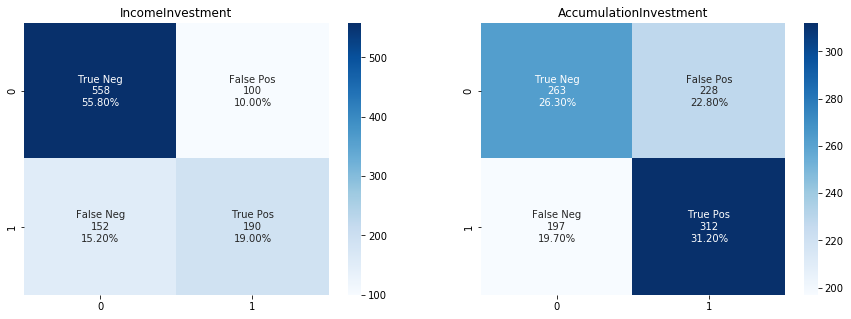

In [9]:
#Valuation of logistic models
confusionMat(predLogInc, predLogAcc, Inc_test, Acc_test)

For the logistic models, the result is not bad especially for the IncomeInvestment model. We can calibrate the parameters for see if we can significatvly improve the models.

#### Random Forest Classifier

Measures for IncomeInvestment:
Sensitivity = 63.16% ;  Specificity = 94.22% ; Precision = 85.04% ; F1 score = 72.48% ; Accuracy = 83.60% ; Zmetric = 71.33% 

Measures for AccumulationInvestment
Sensitivity = 71.71% ;  Specificity = 85.74% ; Precision = 83.91% ; F1 score = 77.33% ; Accuracy = 78.60% ; Zmetric = 74.47% 



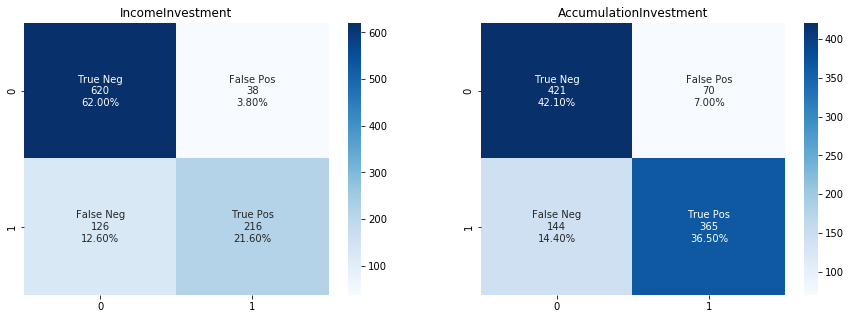

In [10]:
#Valuation of random Forest models
confusionMat(predRFInc, predRFAcc, Inc_test, Acc_test)

The results of the models are very good. The precision and accuracy are very hight. We can try to improve the models via the hyperparameters.

#### Artificial Neural Network

In [11]:
#threshold = [0.22, 0.23, 0.24, 0.25, 0.28, 0.3, 0.33, 0.36, 0.38, 0.4, 0.44, 0,48]
#for t in threshold:
#    _, xTest, __, incTest = train_test_split(X, t_inc, test_size=0.2, shuffle=True, random_state=5)
#    iPred = (predNnInc > t).astype(int)
#    aPred = (predNnAcc > t).astype(int)
#    print("For ", t, " we have :")
#    confusionMat(iPred, aPred, Inc_test, Acc_test)

Measures for IncomeInvestment:
Sensitivity = 58.19% ;  Specificity = 94.07% ; Precision = 83.61% ; F1 score = 68.62% ; Accuracy = 81.80% ; Zmetric = 67.63% 

Measures for AccumulationInvestment
Sensitivity = 67.58% ;  Specificity = 91.24% ; Precision = 88.89% ; F1 score = 76.79% ; Accuracy = 79.20% ; Zmetric = 72.23% 



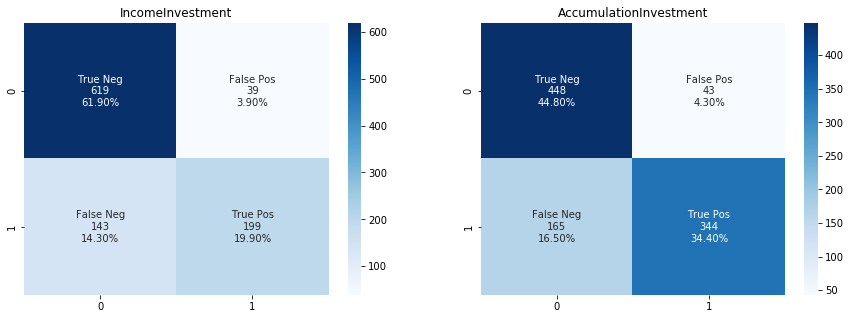

In [12]:
#Valuation of neural Networks models
iPred = (predNnInc > 0.5).astype(int)
aPred = (predNnAcc > 0.5).astype(int)

confusionMat(iPred, aPred, Inc_test, Acc_test)

Neural Networks model is fine for the IncomeInvestment model but for the AccumulationInvestment, is bad. We didn't exepct that so we can try to improve it. 

## Model Selection and explanations

Finally, due to the good result, we choose to keep the random forest classifier for the IncomeInvesstisment target and the ensemble artificial neural network classifier for the AccumulationInvesstisment target.

Now, let try to explain the models with interpretability techniques.

In [13]:
modIncome = rfModInc
modAccumulation = nnAccMod

%store modIncome
%store modAccumulation

Stored 'modIncome' (RandomForestClassifier)


2022-05-27 13:58:46.004984: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://e87dbd5f-748f-4822-9bda-33e9ee47ef24/assets
Stored 'modAccumulation' (list)
